<a href="https://colab.research.google.com/github/mgranchelli/covid19-fake-news-detection/blob/main/fake_news_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import nltk 
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
import pandas as pd
import re
import string
import nltk 
import seaborn as sns 
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import LSTM, Dense, Embedding, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from nltk.corpus import stopwords
stopwords = set(stopwords.words('english'))

In [3]:
import numpy as np
import itertools
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(5, 4))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    #plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.xlabel('Predicted label')
    plt.show()

In [4]:
train = pd.read_csv('./Constraint_English_Train - Sheet1.csv')
val = pd.read_csv('./Constraint_English_Val - Sheet1.csv')
test = pd.read_csv('./english_test_with_labels - Sheet1.csv')

In [5]:
def cleantext(text):
    tx = re.sub(r"http(\S)+",' ',text) 
    tx = tx.replace('&amp',' ')
    tx = tx.translate(str.maketrans('', '', string.punctuation))
    tx = re.sub(r"[^0-9a-zA-Z]+",' ',tx)
    tx = tx.lower().split()
    tx = [x.strip() for x in tx if not x.isdigit()]
    tx = [w for w in tx if not w in stopwords and len(w) > 1]
    tx = " ".join(tx)
    return tx

In [6]:
train['tweet'] = train['tweet'].map(lambda x: cleantext(x))
val['tweet'] = val['tweet'].map(lambda x: cleantext(x))
test['tweet'] = test['tweet'].map(lambda x: cleantext(x))

In [7]:
X_train = train['tweet'].copy()
X_val = val['tweet'].copy()
X_test = test['tweet'].copy()

In [8]:
y_train = (train['label'] == 'real').astype(int)
y_val = (val['label'] == 'real').astype(int)
y_test = (test['label'] == 'real').astype(int)

In [9]:
max_vocab = 10000
tokenizer = Tokenizer(num_words=max_vocab)
tokenizer.fit_on_texts(X_train)

In [10]:
X_train = tokenizer.texts_to_sequences(X_train)
X_val = tokenizer.texts_to_sequences(X_val)
X_test = tokenizer.texts_to_sequences(X_test)

In [11]:
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train, padding='post', maxlen=128)
X_val = tf.keras.preprocessing.sequence.pad_sequences(X_val, padding='post', maxlen=128)
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, padding='post', maxlen=128)

In [12]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(max_vocab, 32),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(16, activation="relu"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          320000    
                                                                 
 bidirectional (Bidirectiona  (None, None, 128)        49664     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 32)               18560     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 64)                2112      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 16)                1

In [13]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
model.compile(loss="mse",
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [14]:
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_val, y_val), callbacks=[early_stop])

Epoch 1/20
201/201 [==============================] - 21s 34ms/step - loss: 0.4451 - accuracy: 0.4783 - val_loss: 0.2899 - val_accuracy: 0.4766
Epoch 2/20
201/201 [==============================] - 5s 23ms/step - loss: 0.3457 - accuracy: 0.5092 - val_loss: 0.2282 - val_accuracy: 0.5051
Epoch 3/20
201/201 [==============================] - 5s 23ms/step - loss: 0.2542 - accuracy: 0.6514 - val_loss: 0.1329 - val_accuracy: 0.8542
Epoch 4/20
201/201 [==============================] - 5s 24ms/step - loss: 0.1920 - accuracy: 0.7436 - val_loss: 0.0974 - val_accuracy: 0.9065
Epoch 5/20
201/201 [==============================] - 5s 23ms/step - loss: 0.1595 - accuracy: 0.7910 - val_loss: 0.0986 - val_accuracy: 0.9023
Epoch 6/20
201/201 [==============================] - 5s 23ms/step - loss: 0.1326 - accuracy: 0.8302 - val_loss: 0.0745 - val_accuracy: 0.9159
Epoch 7/20
201/201 [==============================] - 5s 23ms/step - loss: 0.1228 - accuracy: 0.8469 - val_loss: 0.0945 - val_accuracy: 0.891

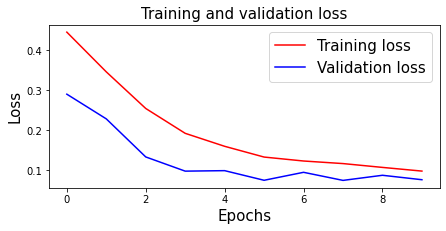

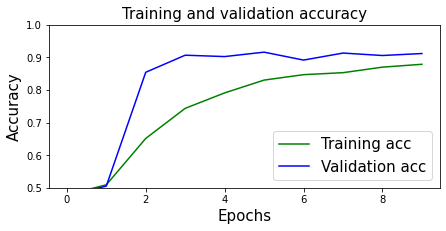

In [15]:
import matplotlib.pyplot as plt 
history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']
epochs = history.epoch

plt.figure(figsize=(7,3))
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss', size=15)
plt.xlabel('Epochs', size=15)
plt.ylabel('Loss', size=15)
plt.legend(prop={'size': 15})
plt.show()

plt.figure(figsize=(7,3))
plt.plot(epochs, acc, 'g', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy', size=15)
plt.xlabel('Epochs', size=15)
plt.ylabel('Accuracy', size=15)
plt.legend(prop={'size': 15})
plt.ylim((0.5,1))
plt.show()

In [16]:
model.evaluate(X_test, y_test)

67/67 [==============================] - 1s 10ms/step - loss: 0.0696 - accuracy: 0.9187


[0.06964901834726334, 0.9186915755271912]

In [17]:
pred = model.predict(X_test)

binary_predictions = []

for i in pred:
    if i >= 0.5:
        binary_predictions.append(1)
    else:
        binary_predictions.append(0) 

In [18]:

print('Accuracy on testing set:', accuracy_score(binary_predictions, y_test))
print('Precision on testing set:', precision_score(binary_predictions, y_test))
print('Recall on testing set:', recall_score(binary_predictions, y_test))

Accuracy on testing set: 0.9186915887850468
Precision on testing set: 0.9419642857142857
Recall on testing set: 0.9063573883161512


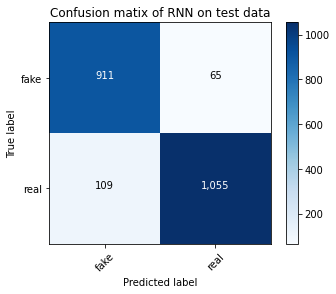

In [19]:
plot_confusion_matrix(confusion_matrix(binary_predictions, y_test), 
                      target_names=['fake','real'], 
                      normalize = False,
                      title = 'Confusion matix of RNN on test data')